In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
with open(f"../results/training_in_forces.npy", "rb") as f:
    training_in = np.load(f)

with open(f"../results/training_out_forces.npy", "rb") as f:
    training_out = np.load(f)

In [4]:
training_in.shape

trainX_t = torch.tensor(training_in, dtype=torch.float32)
trainY_t = torch.tensor(training_out[:, -1, :], dtype=torch.float32)

In [5]:
# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Generate synthetic sine wave data
t = np.linspace(0, 100, 1000)
data = np.sin(t)

# Function to create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(data, seq_length)

print(np.array(X).shape)
print(np.array(y).shape)

# Convert data to PyTorch tensors
trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

print(trainX.shape)
print(trainY.shape)

(990, 10)
(990,)
torch.Size([990, 10, 1])
torch.Size([990, 1])


In [6]:
trainX

tensor([[[ 0.0000],
         [ 0.0999],
         [ 0.1989],
         ...,
         [ 0.6448],
         [ 0.7179],
         [ 0.7839]],

        [[ 0.0999],
         [ 0.1989],
         [ 0.2958],
         ...,
         [ 0.7179],
         [ 0.7839],
         [ 0.8420]],

        [[ 0.1989],
         [ 0.2958],
         [ 0.3898],
         ...,
         [ 0.7839],
         [ 0.8420],
         [ 0.8917]],

        ...,

        [[-0.9870],
         [-0.9981],
         [-0.9992],
         ...,
         [-0.8581],
         [-0.8024],
         [-0.7388]],

        [[-0.9981],
         [-0.9992],
         [-0.9904],
         ...,
         [-0.8024],
         [-0.7388],
         [-0.6677]],

        [[-0.9992],
         [-0.9904],
         [-0.9716],
         ...,
         [-0.7388],
         [-0.6677],
         [-0.5900]]])

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        # If hidden and cell states are not provided, initialize them as zeros
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward pass through LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Selecting the last output
        return out, hn, cn

In [8]:
trainY_t.shape

torch.Size([6, 42])

In [9]:
# Initialize model, loss, and optimizer
model = LSTMModel(input_dim=42, hidden_dim=100, layer_dim=1, output_dim=42)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
h0, c0 = None, None  # Initialize hidden and cell states

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs, h0, c0 = model(trainX_t, h0, c0)

    # Compute loss
    loss = criterion(outputs, trainY_t)
    loss.backward()
    optimizer.step()

    # Detach hidden and cell states to prevent backpropagation through the entire sequence
    h0 = h0.detach()
    c0 = c0.detach()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 121006104.0000
Epoch [200/1000], Loss: 120059320.0000
Epoch [300/1000], Loss: 119120344.0000
Epoch [400/1000], Loss: 118212752.0000
Epoch [500/1000], Loss: 117295464.0000
Epoch [600/1000], Loss: 116393816.0000
Epoch [700/1000], Loss: 115499952.0000
Epoch [800/1000], Loss: 114613072.0000
Epoch [900/1000], Loss: 114112248.0000
Epoch [1000/1000], Loss: 113179800.0000


In [10]:
trainX_t[-2:-1, :400, :].shape

torch.Size([1, 400, 42])

In [11]:
predicted_400, h400, c400 = model(trainX_t[-2:-1, :400, :], None, None)

In [12]:
predicted_401, _, _ = model(trainX_t[-2:-1, 400:401, :], h400, c400)

In [13]:
predicted_401_comp, _, _ = model(trainX_t[-2:-1, :401, :], None, None)

In [22]:
predicted_test, _, _ = model(torch.tensor(training_in[-2:-1, :401, :], dtype=torch.float32), None, None)

In [14]:
predicted_400

tensor([[ 5.1011e-02, -7.9783e+02,  5.7302e-02, -8.0015e+02,  1.6987e-01,
         -8.0121e+02,  2.0602e-01, -8.0164e+02, -1.0610e-01, -8.0236e+02,
         -1.8746e-01, -8.0159e+02, -1.3120e-01, -8.0154e+02, -8.6588e-02,
         -8.0139e+02, -1.3948e-01, -8.0149e+02,  3.6454e-02, -8.0206e+02,
         -5.9216e-02, -8.0128e+02, -7.4794e-02, -8.0190e+02, -1.2873e-01,
         -8.0150e+02, -1.0366e-01, -8.0056e+02, -3.2666e-02, -8.0249e+02,
         -7.1958e-02, -8.0187e+02,  9.7483e-03, -8.0274e+02,  7.4667e-02,
         -8.0083e+02,  1.1713e-01, -8.0046e+02,  1.2713e-01, -8.0058e+02,
          7.4167e-02, -7.9792e+02]], grad_fn=<AddmmBackward0>)

In [15]:
predicted_401

tensor([[ 4.8909e-02, -7.9837e+02,  5.7383e-02, -8.0069e+02,  1.7005e-01,
         -8.0176e+02,  2.0392e-01, -8.0219e+02, -1.0399e-01, -8.0291e+02,
         -1.8729e-01, -8.0214e+02, -1.2920e-01, -8.0209e+02, -8.5328e-02,
         -8.0194e+02, -1.3785e-01, -8.0204e+02,  3.6591e-02, -8.0260e+02,
         -5.9354e-02, -8.0182e+02, -7.6469e-02, -8.0245e+02, -1.2711e-01,
         -8.0205e+02, -1.0428e-01, -8.0111e+02, -3.3544e-02, -8.0304e+02,
         -7.2939e-02, -8.0241e+02,  9.8125e-03, -8.0329e+02,  7.2461e-02,
         -8.0138e+02,  1.1955e-01, -8.0100e+02,  1.2635e-01, -8.0113e+02,
          7.3753e-02, -7.9846e+02]], grad_fn=<AddmmBackward0>)

In [16]:
predicted_401_comp

tensor([[ 4.8909e-02, -7.9837e+02,  5.7383e-02, -8.0069e+02,  1.7005e-01,
         -8.0176e+02,  2.0392e-01, -8.0219e+02, -1.0399e-01, -8.0291e+02,
         -1.8729e-01, -8.0214e+02, -1.2920e-01, -8.0209e+02, -8.5328e-02,
         -8.0194e+02, -1.3785e-01, -8.0204e+02,  3.6591e-02, -8.0260e+02,
         -5.9354e-02, -8.0182e+02, -7.6469e-02, -8.0245e+02, -1.2711e-01,
         -8.0205e+02, -1.0428e-01, -8.0111e+02, -3.3544e-02, -8.0304e+02,
         -7.2939e-02, -8.0241e+02,  9.8125e-03, -8.0329e+02,  7.2461e-02,
         -8.0138e+02,  1.1955e-01, -8.0100e+02,  1.2635e-01, -8.0113e+02,
          7.3753e-02, -7.9846e+02]], grad_fn=<AddmmBackward0>)

In [23]:
predicted_test

tensor([[ 4.8909e-02, -7.9837e+02,  5.7383e-02, -8.0069e+02,  1.7005e-01,
         -8.0176e+02,  2.0392e-01, -8.0219e+02, -1.0399e-01, -8.0291e+02,
         -1.8729e-01, -8.0214e+02, -1.2920e-01, -8.0209e+02, -8.5328e-02,
         -8.0194e+02, -1.3785e-01, -8.0204e+02,  3.6591e-02, -8.0260e+02,
         -5.9354e-02, -8.0182e+02, -7.6469e-02, -8.0245e+02, -1.2711e-01,
         -8.0205e+02, -1.0428e-01, -8.0111e+02, -3.3544e-02, -8.0304e+02,
         -7.2939e-02, -8.0241e+02,  9.8125e-03, -8.0329e+02,  7.2461e-02,
         -8.0138e+02,  1.1955e-01, -8.0100e+02,  1.2635e-01, -8.0113e+02,
          7.3753e-02, -7.9846e+02]], grad_fn=<AddmmBackward0>)

ValueError: x and y must have same first dimension, but have shapes (990,) and (6, 42)

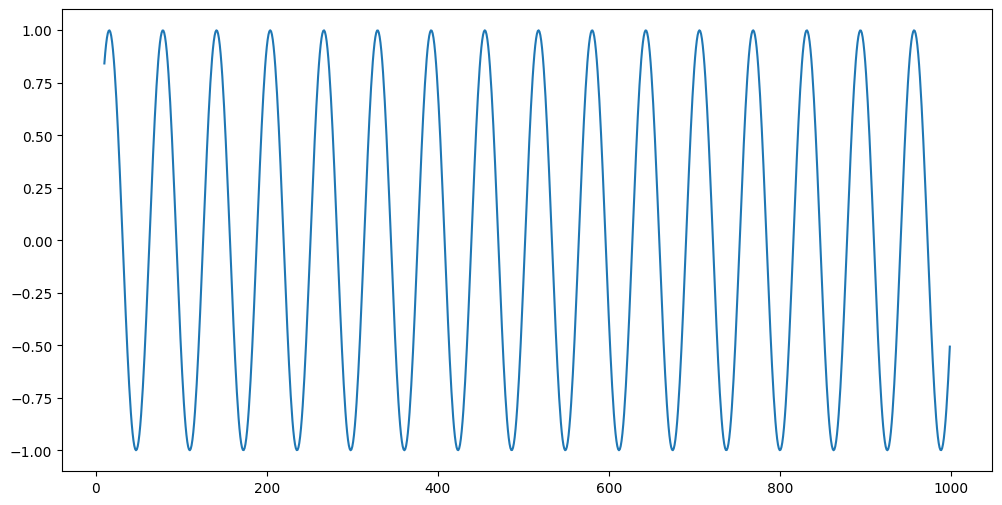

In [17]:
# Predicted outputs
model.eval()
predicted, _, _ = model(trainX_t, h0, c0)

# Adjusting the original data and prediction for plotting
original = data[seq_length:]  # Original data from the end of the first sequence
time_steps = np.arange(seq_length, len(data))  # Corresponding time steps

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted.detach().numpy(), label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()